# Generate a single voxel (SVS) NIfTI-MRS example manually
The aim of this notebook is to elucidate the different parts of a NIfTI-MRS format file.  
Some calculations and manipulations are made transparent and explicit here, but others (e.g. orientation calculations) are still done by functions implemented in the spec2nii conversion program.

Data is taken from a single subject's STEAM SVS scan on a Siemens MAGNETOM 7T (VB platform). The data is stored in the Siemens proprietary Twix (.dat) format. The data is water-suppressed, has uncombined coils, and multiple repeated temporal dynamics.

## Dependencies
These dependencies can be downloaded by following the instructions in the README.md file and installing using the requirements.txt file.

In [2]:
from mapvbvd import mapVBVD
from pathlib import Path
import numpy as np
import h5py
import datetime
import json
import nibabel as nib
import matplotlib.pyplot as plt

from spec2nii.twixfunctions import twix2DCMOrientation,examineTwix,extractTwixMetadata
from spec2nii.dcm2niiOrientation.orientationFuncs import nifti_dicom2mat
from spec2nii.nifti_orientation import NIFTIOrient

### Load the data using the pyMapVBVD package
This package reads data in the Siemens 'raw' Twix (.dat) format.

In [29]:
supressed_file = Path('../data/meas_MID310_STEAM_metab_FID115673.dat')

suppressed_raw = mapVBVD(supressed_file,quiet=True)

### Extract data
Extract the blocks of data and pad with three singleton spatial dimensions.  
We expect 4096 points, 32 coils and multiple averages.  
We choose to remove the oversampling.

In [30]:
suppressed_raw.image.removeOS = True
supp_block = suppressed_raw.image.unsorted()
print(f'Raw data shape: {supp_block.shape}')

# Add three singleton dimensions for spatial x, y, and z.
newshape = (1,1,1)+supp_block.shape
supp_block = supp_block.reshape(newshape)
print(f'Data shape: {supp_block.shape}')

read data:   0%|          | 0/64 [00:00<?, ?it/s]

Raw data shape: (2048, 32, 64)
Data shape: (1, 1, 1, 2048, 32, 64)


Plot the data from a single coil and dynamic

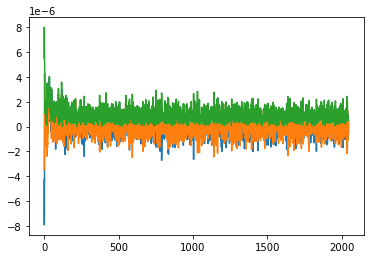

In [5]:
plt.plot(np.real(supp_block[0,0,0,:,0,0]))
plt.plot(np.imag(supp_block[0,0,0,:,0,0]))
plt.plot(np.abs(supp_block[0,0,0,:,0,0]))
plt.show()

### Voxel orientation calculations
Here we are converting specific twix header values into a NIfTI affine position/orientation matrix.  
The affine matrix encodes the position, orientation (rotation), and size of the voxel in a single 4x4 matrix.  
The calculation is done here in two steps:
1) translation of the specific Twix (.dat) headers into DICOM style imageOrientationPatient, imagePositionPatient, pixelSpacing, and slicethickness tags,
2) conversion of DICOM style tags into the NIfTI affine.

We will use code from spec2nii's specific twix implementation.

In [6]:
# Orientation calculations
#1) Calculate dicom like imageOrientationPatient,imagePositionPatient,pixelSpacing and slicethickness
imageOrientationPatient,imagePositionPatient,pixelSpacing,slicethickness = twix2DCMOrientation(suppressed_raw['hdr'],False)

print(f'imageOrientationPatient:\n {imageOrientationPatient}')
print(f'imagePositionPatient:\n {imagePositionPatient}')
print(f'pixelSpacing:\n {pixelSpacing}')
print(f'slicethickness:\n {slicethickness}')

# 2) in style of dcm2niix
# a) calculate Q44
xyzMM = np.append(pixelSpacing,slicethickness)
Q44 = nifti_dicom2mat(imageOrientationPatient,imagePositionPatient,xyzMM,verbose=False)
# b) calculate nifti quaternion parameters
Q44[:2,:] *= -1
# 3) place in data class for nifti orientation parameters  
currNiftiOrientation = NIFTIOrient(Q44)

print(f'NIfTI affine:')
print(currNiftiOrientation.Q44)

imageOrientationPatient:
 [[-1.  0.  0.]
 [ 0.  1. -0.]]
imagePositionPatient:
 [ 32.90067836 -10.6633755   21.35589036]
pixelSpacing:
 [20. 20.]
slicethickness:
 20.0
NIfTI affine:
[[ 20.          -0.          -0.         -32.90067836]
 [ -0.         -20.          -0.          10.6633755 ]
 [  0.           0.         -20.          21.35589036]
 [  0.           0.           0.           1.        ]]


### Metadata
In this section we manually assemble the meta-data that is required by, or may otherwise be stored in, NIfTI-MRS
#### Dimension information
First is the information about the higher data dimensions (the 5th - 7th dimensions)  

In this data only the 5th and 6th dimensions are used, for the uncombined coils and temporal signal averages respectively. 
We therefore label the dimensions *DIM_COIL* and *DIM_DYN*. Additionally (and optionally) we give a bit more information about the use in the 6th dimension.

In [7]:
dim_dict = {'dim_5': 'DIM_COIL',
            'dim_6': 'DIM_DYN',
            'dim_6_use': 'Signal repetitions'}

#### Metadata required for minimum conformance
Three pieces of data **must** be specified for conformanace with the standard.

<ins>In the header extension</ins>  
**SpectrometerFrequency** , Array of doubles, See DICOM tag (0018,9098). Units: MHz.  
**ResonantNucleus**, Array of strings, See DICOM tag (0018,9100). Must be one of the DICOM recognized nuclei “1H”, “3HE”, “7LI”, “13C”, “19F”, “23NA”, “31P”, “129XE” or one named in the specified format. I.e. Mass number followed by the chemical symbol in uppercase.  

<ins>In the NIfTI header block</ins>   
**Dwelltime**. Units: s.  **Stored in pixdim[4]**

In [16]:
dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9 # For nifti pixel dim
dwelltime *=2 # Oversampling was removed
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
nucleus_str = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'tNucleus')].strip('"')

print(f'SpectrometerFrequency = {transmitter_frequency_mhz:0.6f} MHz')
print(f'ResonantNucleus = {nucleus_str}')
print(f'dwelltime = {dwelltime:0.2e} s')


SpectrometerFrequency = 297.219948 MHz
ResonantNucleus = 1H
dwelltime = 1.67e-04 s


#### Extract some optional standard-defined metadata as well 
The NIfTI-MRS standard includes definitions of some common MRS metadata.  
Though the use of it is optional, here we populate some of those fields for illustration. 
  
Include:  
**EchoTime**, double, Time from centroid of excitation to start of FID or centre of echo. Units: Seconds  
**RepetitionTime**, double, Sequence repetition time. Units: Seconds  
**InversionTime**, double, Inversion time. Units: Seconds  
**MixingTime**, double, Mixing time in e.g. STEAM sequence. Units: Seconds

Some standard-defined conversion metadata:  
**ConversionMethod**, String, Program used for conversion. May include additional information like software version.  
**ConversionTime**, String:  “YYYY-MM-DDThh:mm:ss.sss”, Time and date of conversion. ISO 8601 compliant format  
**OriginalFile**, String, Name and extension of the original file  

In [17]:
echo_time_s = suppressed_raw['hdr']['MeasYaps'][('alTE', '0')]/1E6
repetition_time_s = suppressed_raw['hdr']['MeasYaps'][('alTR', '0')]/1E6
inversion_time_s = None
mixing_time_s = suppressed_raw['hdr']['MeasYaps'][('alTD', '0')]/1E6

print(f'EchoTime = {echo_time_s:0.3f} s')
print(f'RepetitionTime = {repetition_time_s:0.3f} s')
print(f'InversionTime = {inversion_time_s} s')
print(f'MixingTime = {mixing_time_s:0.3f} s')

conversion_method = 'Manual'
conversion_time = datetime.datetime.now().isoformat(sep='T',timespec='milliseconds')
original_file = [str(supressed_file.name)]

print(f'ConversionMethod = {conversion_method}')
print(f'ConversionTime = {conversion_time}')
print(f'OriginalFile = {original_file}')

EchoTime = 0.011 s
RepetitionTime = 5.000 s
InversionTime = None s
MixingTime = 0.032 s
ConversionMethod = Manual
ConversionTime = 2021-06-30T14:25:12.830
OriginalFile = ['meas_MID310_STEAM_metab_FID115673.dat']


#### Add some user-defined meta-data
In addition to the standard-defined metadata, users may define their own arbitrary metadata. This metadata must not redefine keys reserved in the standard. Users are encouraged to include in-place documentation for this metadata. The information is stored as a JSON object with a reserved 'Description' key for the in-place documentation.

Here we store the paths to the sequence binary and reconstruction program on the scanner, providing certainty of the sequence used.

In [18]:
siemens_sequence_info = {'Description': 'Paths to sequence and reconstruction code binaries for sequence identification.',
                         'sequence': suppressed_raw['hdr']['Config'][('SequenceFileName')],
                         'recon': suppressed_raw['hdr']['Meas'][('tICEProgramName')]}

## Make the JSON string representation of the metadata
Use Python's inbuilt json library to convert a combined dict of metadata into the header extension string.  

In [31]:
metadata_dict = {**dim_dict,
                'SpectrometerFrequency':[transmitter_frequency_mhz,],
                'ResonantNucleus':[nucleus_str,],
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime': conversion_time,
                'OriginalFile': original_file,
                'siemens_sequence_info': siemens_sequence_info}

json_meta= json.dumps(metadata_dict)
print(json_meta)

{"dim_5": "DIM_COIL", "dim_6": "DIM_DYN", "dim_6_use": "Signal repetitions", "SpectrometerFrequency": [297.219948], "ResonantNucleus": ["1H"], "EchoTime": 0.011, "RepetitionTime": 5.0, "InversionTime": null, "MixingTime": 0.032, "ConversionMethod": "Manual", "ConversionTime": "2021-06-30T14:25:12.830", "OriginalFile": ["meas_MID310_STEAM_metab_FID115673.dat"], "siemens_sequence_info": {"Description": "Paths to sequence and reconstruction code binaries for sequence identification.", "sequence": "%CustomerSeq%\\uzay_steam_gui", "recon": "%CustomerIceProgs%\\uzayIcePrgSpecOnline"}}


## Data conventions
NIfTI-MRS defines a strict phase and frequency convention. This is to ensure that spectra are displayed consistently.  
Here we ensure that this data conforms to this convention by plotting it.
The convention states:
- The frequency scale should increase from left to right. For nuclei with a gyromagnetic ratio > 0 this corresponds to resonances from nuclei with less shielding (more deshielding) and therefore experiencing a higher magnetic field, appearing on the left. I.e. they have more negative (higher magnitude) Larmor frequencies noting $\omega=-\gamma B_0$.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time) in the time-domain:  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.  

Note that in literature the frequency is often also plotted with a different frequency scale showing more positive relative frequencies on the left. This preserves the orientation of the spectrum but corresponds to a scale equal to  $|\omega|-|\omega_{\textrm{ref}}|$.

Here the data doesn't match the convention so the first thing we do is conjugate the time-domain data



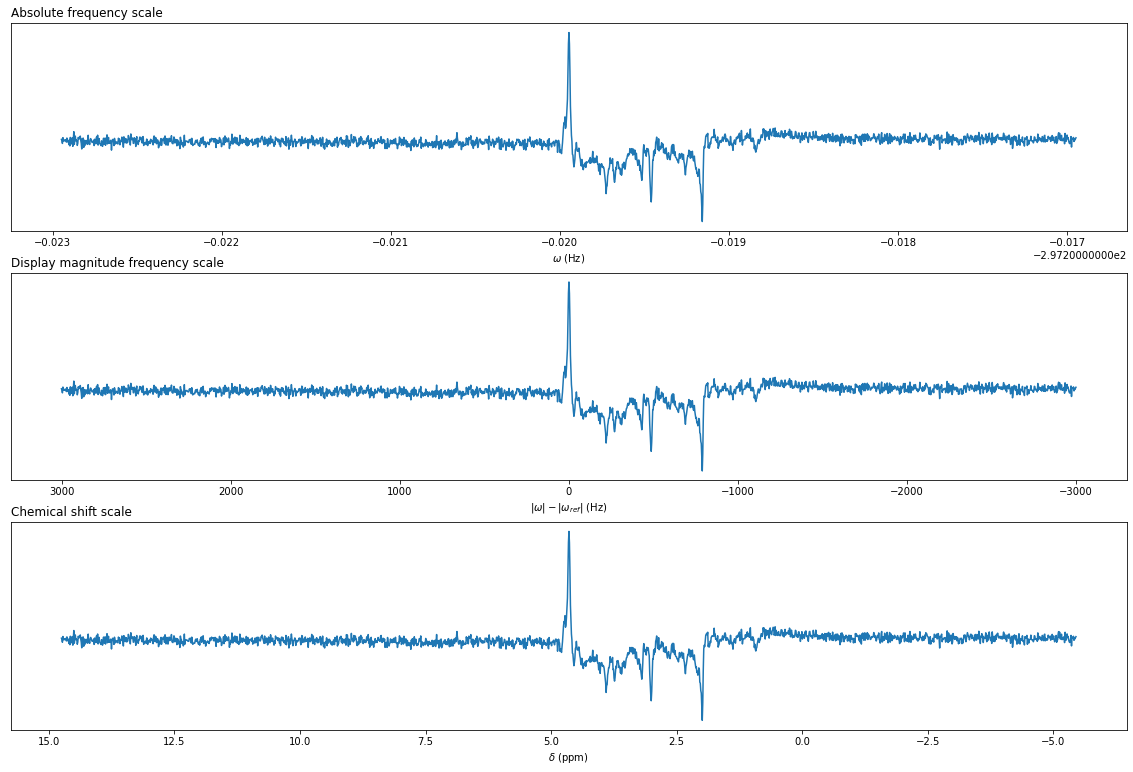

In [21]:
supp_block = supp_block.conj()

# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
spectral_width_hz = 1/dwelltime
npoints = supp_block.shape[3]
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = 4.65+ frequency_axis/transmitter_frequency_mhz

test_FID = np.mean(supp_block[0,0,0,:,0,:],axis=1)

spec_fft = np.fft.fftshift(np.fft.fft(test_FID))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

## Write the NIfTI-MRS file 
Using the NIfTI-2 format as recommended (but not required) by the specification.

In [25]:
save_path = Path('../examples')

newobj = nib.nifti2.Nifti2Image(supp_block, currNiftiOrientation.Q44)

# Write new header with the dwell time
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_3'

# Write extension with ecode 44
extension = nib.nifti1.Nifti1Extension(44, json_meta.encode('UTF-8'))
newobj.header.extensions.append(extension)

# Form nifti obj and write    
nib.save(newobj, save_path / 'example_01.nii.gz')

### Save out hdf5 versions of data
This is done to provide data for validation of any new reader.

In [27]:
with h5py.File(save_path / 'example_01.h5', 'w') as h5f:
    h5f.create_dataset('example_1_data', data=supp_block)
    h5f.create_dataset('example_1_header_ext', data=json_meta)

## Load and check what we have written
Python nibabel library works both ways!

In [28]:
check_nifti = nib.load(save_path / 'example_01.nii.gz')

with h5py.File(save_path / 'example_01.h5','r') as h5f:
    check_hdf5 = h5f['example_1_data'][:]
    
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64), supp_block)
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64), check_hdf5)

loaded_he_content = json.loads(check_nifti.header.extensions[0].get_content())

assert loaded_he_content == metadata_dict
